In [2]:
!pip install qiskit qiskit_aer


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [3]:
# --- Importing Required Libraries (Qiskit 1.x Compatible) ---

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import math, warnings

# Qiskit Aer is now a separate package
try:
    from qiskit_aer import AerSimulator, noise
    from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError
    backend_sim = AerSimulator()
    print("✅ Qiskit AerSimulator loaded successfully.")
except ImportError as e:
    backend_sim = None
    warnings.warn("⚠️ Qiskit Aer is not installed. Install it using: pip install qiskit-aer")


✅ Qiskit AerSimulator loaded successfully.


In [4]:
#  Task 1: Change the Marked State 

marked_state='101'
qc = QuantumCircuit(3, 3)

# Step 1: Apply Hadamard to all qubits
qc.h(range(3))

# Step 2: Oracle for the marked state
for i, bit in enumerate(marked_state):
    if bit == '0':
        qc.x(i)
qc.h(2)
qc.ccx(0, 1, 2)
qc.h(2)
for i, bit in enumerate(marked_state):
    if bit == '0':
        qc.x(i)

# Step 3: Diffuser (inversion about the mean)
qc.h(range(3))
qc.x(range(3))
qc.h(2)
qc.ccx(0, 1, 2)
qc.h(2)
qc.x(range(3))
qc.h(range(3))

# Step 4: Measurement
qc.measure(range(3), range(3))

# Transpile and simulate
job = backend_sim.run(qc)
result = job.result()
counts = result.get_counts()

# Plot
print(f"🔹 Marked state searched: {marked_state}")
plot_histogram(counts)
plt.show()

🔹 Marked state searched: 101


In [5]:
# Task 2: Modify the Number of Qubits

marked = '0110'  # 🟢 Change this to any 4-bit state (e.g., '1001', '1111')
n = 4
qc = QuantumCircuit(n, n)

# Step 1: Apply Hadamard to all qubits
qc.h(range(n))

# Step 2: Oracle for the marked state
# Flip qubits that are |0> in the marked state
for i, bit in enumerate(marked_state):
    if bit == '0':
        qc.x(i)

# Multi-controlled Z gate using H + multi-controlled X
qc.h(n - 1)
qc.mcx(list(range(n - 1)), n - 1)  # Controlled on all but last qubit
qc.h(n - 1)

# Undo the earlier X gates
for i, bit in enumerate(marked_state):
    if bit == '0':
        qc.x(i)

# Step 3: Diffuser (inversion about mean)
qc.h(range(n))
qc.x(range(n))
qc.h(n - 1)
qc.mcx(list(range(n - 1)), n - 1)
qc.h(n - 1)
qc.x(range(n))
qc.h(range(n))

# Step 4: Measurement
qc.measure(range(n), range(n))

# Simulate
job = backend_sim.run(qc)
result = job.result()
counts = result.get_counts()

# Plot
print(f"🔹 Marked state searched (4-qubit): {marked}")
plot_histogram(counts)
plt.show()

🔹 Marked state searched (4-qubit): 0110


In [6]:
# Task 3: Add Multiple Iterations
def oracle(qc, marked_state):
    n = len(marked_state)
    for i, bit in enumerate(marked_state):
        if bit == '0':
            qc.x(i)
    qc.h(n - 1)
    qc.mcx(list(range(n - 1)), n - 1)
    qc.h(n - 1)
    for i, bit in enumerate(marked_state):
        if bit == '0':
            qc.x(i)

def diffuser(qc, n):
    qc.h(range(n))
    qc.x(range(n))
    qc.h(n - 1)
    qc.mcx(list(range(n - 1)), n - 1)
    qc.h(n - 1)
    qc.x(range(n))
    qc.h(range(n))

def grover_with_iterations(marked_state='1011', iterations=3):
    n = len(marked_state)
    qc = QuantumCircuit(n, n)

    # Step 1: Apply Hadamard
    qc.h(range(n))

    # Step 2: Repeat oracle + diffuser
    for _ in range(iterations):
        oracle(qc, marked_state)
        diffuser(qc, n)

    # Step 3: Measurement
    qc.measure(range(n), range(n))

    return qc


marked = '1011'
num_iterations = 3  
qc_iter = grover_with_iterations(marked, num_iterations)

# Simulate
job = backend_sim.run(qc_iter)
result = job.result()
counts = result.get_counts()

# Plot
print(f"🔹 Marked state: {marked}, Iterations: {num_iterations}")
plot_histogram(counts)
plt.show()

🔹 Marked state: 1011, Iterations: 3


In [7]:
#Task 4: Circuit Visualization 

marked = '1011'
num_iterations = 3

qc_vis = grover_with_iterations(marked, num_iterations)

print(f"🔹 Visualizing Grover circuit for marked state: {marked} with {num_iterations} iterations\n")
print(qc_vis.draw('text'))  # Shows a clean ASCII diagram


🔹 Visualizing Grover circuit for marked state: 1011 with 3 iterations

     ┌───┐          ┌───┐┌───┐               ┌───┐┌───┐               ┌───┐»
q_0: ┤ H ├───────■──┤ H ├┤ X ├────────────■──┤ X ├┤ H ├────────────■──┤ H ├»
     ├───┤┌───┐  │  ├───┤├───┤┌───┐       │  ├───┤├───┤┌───┐       │  ├───┤»
q_1: ┤ H ├┤ X ├──■──┤ X ├┤ H ├┤ X ├───────■──┤ X ├┤ H ├┤ X ├───────■──┤ X ├»
     ├───┤└───┘  │  ├───┤├───┤└───┘       │  ├───┤├───┤└───┘       │  ├───┤»
q_2: ┤ H ├───────■──┤ H ├┤ X ├────────────■──┤ X ├┤ H ├────────────■──┤ H ├»
     ├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐┌───┐┌─┴─┐├───┤├───┤┌───┐┌───┐┌─┴─┐├───┤»
q_3: ┤ H ├┤ H ├┤ X ├┤ H ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ H ├┤ X ├┤ H ├»
     └───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘»
c: 4/══════════════════════════════════════════════════════════════════════»
                                                                           »
«     ┌───┐               ┌───┐┌───┐               ┌───┐┌───┐               »
«q_0

🔹 Comparing Ideal vs Noisy Simulation Results


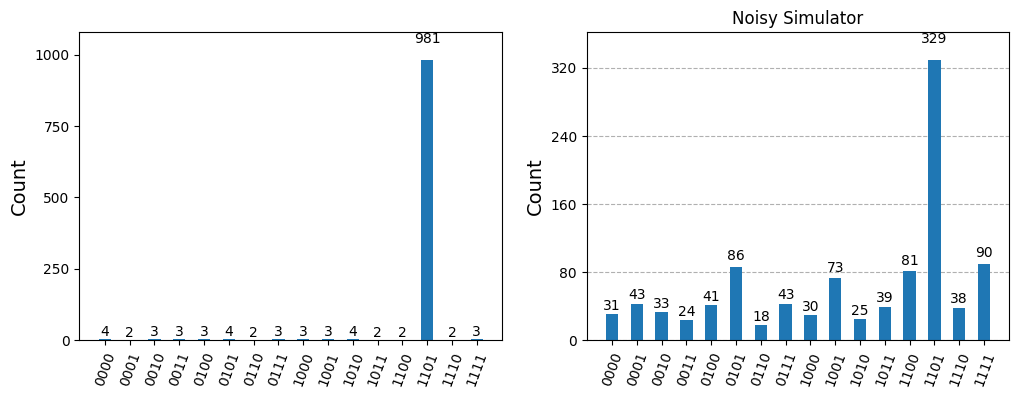

In [8]:
# Task 5: Experiment with Noise 

from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError

def create_noise_model():
    noise_model = NoiseModel()

    # Define small depolarizing errors for 1- and 2-qubit gates
    error_1 = depolarizing_error(0.02, 1)
    error_2 = depolarizing_error(0.04, 2)

    # Define readout error (measurement)
    readout_error = ReadoutError([[0.9, 0.1],
                                  [0.1, 0.9]])

    # Add errors to model
    noise_model.add_all_qubit_quantum_error(error_1, ['x', 'h'])
    noise_model.add_all_qubit_quantum_error(error_2, ['cx'])
    noise_model.add_all_qubit_readout_error(readout_error)

    return noise_model


noise_model = create_noise_model()

marked = '1011'
num_iterations = 3
qc_noise = grover_with_iterations(marked, num_iterations)

# --- Run Ideal Simulation ---
ideal_job = backend_sim.run(qc_noise)
ideal_counts = ideal_job.result().get_counts()

# --- Run Noisy Simulation ---
noisy_backend = AerSimulator(noise_model=noise_model)
noisy_job = noisy_backend.run(qc_noise)
noisy_counts = noisy_job.result().get_counts()

# --- Compare Results ---
print("🔹 Comparing Ideal vs Noisy Simulation Results")
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_histogram(ideal_counts, title="Ideal Simulator", ax=ax[0])
plot_histogram(noisy_counts, title="Noisy Simulator", ax=ax[1])
plt.show()